# 3. Feature Engineering

In [1]:
# Basic python packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Packages used for extracting business features
import re
from uszipcode import SearchEngine
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
# Packages used for review text features
from textblob import TextBlob
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import Phrases, TfidfModel, LdaModel, CoherenceModel

## 3.1 Extract Business Features

In [4]:
# Read business data and checkin data
business = pd.read_csv('clean_business.csv')
business.shape

(7116, 13)

In [5]:
# Reveal first few rows 
business.head()

,attributes,business_id,categories,city,latitude,longitude,name,postal_code,review_count,stars,state,isBankrupt,county
0,"{'RestaurantsTableService': False, 'GoodForMea...",rDMptJYWtnMhpQu_rRXHng,"['Fast Food', 'Burgers', 'Restaurants']",Phoenix,33.607070,-112.064382,McDonald's,85022,10,1.0,AZ,0,Maricopa County
1,"{'RestaurantsTableService': True, 'GoodForMeal...",1WBkAuQg81kokZIPMpn9Zg,"['Burgers', 'Restaurants']",Phoenix,33.607310,-112.063404,Charr An American Burger Bar,85022,232,3.0,AZ,0,Maricopa County
2,"{'RestaurantsTableService': False, 'GoodForMea...",iPa__LOhse-hobC2Xmp-Kw,"['Restaurants', 'Burgers', 'Fast Food']",Phoenix,33.508765,-112.046240,McDonald's,85016,34,3.0,AZ,0,Maricopa County
3,"{'BusinessAcceptsCreditCards': True, 'Business...",YhV93k9uiMdr3FlV4FHjwA,"['Marketing', ""Men's Clothing"", 'Restaurants',...",Phoenix,33.449967,-112.070222,Caviness Studio,85001,4,5.0,AZ,0,Maricopa County
4,"{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",VdlPZg2NAu8t8GkdbPLecg,"['Restaurants', 'Gluten-Free', 'Indian', 'Seaf...",Scottsdale,33.555212,-111.900456,Tandoori Times Indian Bistro,85258,263,3.5,AZ,0,Maricopa County


In [6]:
# Make a copy of raw dataset
business_df = business.copy()

## 3.1.1 Create isChain

We define restaurant as `isChain` by checking whether or not the name is repeated more than once.

In [7]:
# Create new feature chain
chain_dict = business_df['name'].value_counts().to_dict()
business_df['isChain'] = business_df['name'].apply(lambda x: int(chain_dict[x] > 1))

## Create City Density

We calculate the total number of restaurants in the city that each restaurant resides.

In [8]:
# Create a dictionary to store restuarant number in each city
city_dict = business_df.groupby('city').apply(len).to_dict()

In [9]:
# Create new feature neighborhood_city
business_df['density'] = business_df['city'].apply(lambda city: city_dict.get(city))

## Create Neighborhood Size

To calculate the total number of restaurants in the neighborhood of each restaurant, we need to calculate the distance matrix that summarizes all pairwise distances between all restaurants and then identify all neighborhoods within 1 mile radius using clustering method like `DBSCAN`. 

However, this method is computationally time demanding. Our alternative to this problem is to use K-Means clustering, which can serve as a good approximation for `DBSCAN`. We first use Silhouette score to determine the best number of $K$ and then group the data into $K$ clusters. The number restaurants within each cluster will then be the neighborhood size which we define as `neighborhood`.

In [10]:
# Use Kmeans Clustering to identify grouping by latitude and longitude
def geocluster(data, k_min=2, k_max=2, step=1):
    coordinates = data[['latitude', 'longitude']].copy()
    
    # Compute Silhouette scores for each K
    silhouette = []
    k_range = list(range(k_min, k_max+step, step))
    for i in k_range:
        kmeans = KMeans(n_clusters=i, random_state=314).fit(coordinates)
        
        # Calculate silhouette score based on euclidean distance
        silhouette.append(silhouette_score(coordinates, kmeans.labels_, metric='euclidean'))
        
    return pd.DataFrame(dict(k=k_range, silhouette_score=silhouette))

In [11]:
# Compute silhouette score for different K's
silhouette_result = geocluster(business_df, 20, 1000, 20)
silhouette_result.head();

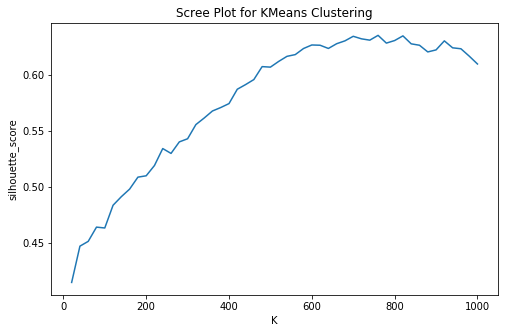

In [12]:
# Plot the silhouette for different K's
plt.figure(figsize=(8,5))
plt.plot(silhouette_result['k'], silhouette_result['silhouette_score'])
plt.xlabel('K')
plt.ylabel('silhouette_score')
plt.title('Scree Plot for KMeans Clustering');

In [13]:
# Get the best number of cluseter K
best_k = silhouette_result['k'][silhouette_result['silhouette_score'].idxmax()]
best_k

760

In [14]:
# Fit Kmeans Model to the coordinates
kmeans = KMeans(n_clusters=best_k, random_state=314).fit(business_df[['latitude', 'longitude']].copy())

# Add the cluster labels to data
business_df['cluster'] = kmeans.labels_

In [15]:
# Calculate number of restaurants in each centroid
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['latitude', 'longitude']) \
                .reset_index() \
                .rename(columns={'index':'k'})
centroids['size'] = business_df.groupby('cluster').size()
centroids.head()

,k,latitude,longitude,size
0,0,33.378323,-112.030133,19
1,1,33.538795,-112.183971,26
2,2,33.378500,-111.786990,26
3,3,33.624828,-111.923824,28
4,4,33.484423,-112.363563,8


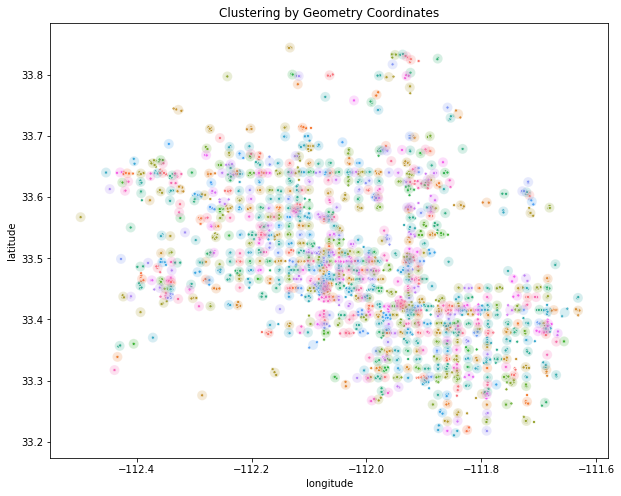

In [16]:
# Visualize the geometry clustering
plt.figure(figsize=(10,8))
cmap=sns.husl_palette(n_colors=best_k)
sns.scatterplot('longitude', 'latitude', hue='cluster', data=business_df, legend=False, s=10, palette=cmap)
sns.scatterplot('longitude', 'latitude', hue='k', data=centroids, legend=False, s=100, alpha=0.2, palette=cmap)
plt.title('Clustering by Geometry Coordinates');

In [17]:
# Compute neighborhood density for each cluster
neighborhood = centroids.set_index('k')['size'].to_dict()
business_df['neighborhood'] = business_df['cluster'].apply(lambda row: neighborhood[row])

## Parse String

In [18]:
# Convert types of attributes and categories to dictionary and list
business_df['attributes'] = business_df['attributes'].apply(lambda x: eval(x))
business_df['categories'] = business_df['categories'].apply(lambda x: eval(x))

## Extract Features From Categories

In [19]:
# Extract all words in categories
categories = np.unique([item for row in business_df['categories'] for item in row])
print("Number of unique words in feature 'categories':", len(categories))

Number of unique words in feature 'categories': 417


Since the words in `categories` list is not much, we will do manually check and split the words in three sub categories. 

### Restaurant categories I - Restaurant Ethnicity

In [20]:
# Ethnics words filtered by manually check
ethnics = ['Afghan', 'African', 'American (New)','American (Traditional)', 'Arabian', 'Argentine',
           'Armenian','Asian Fusion','Australian', 'Austrian','Belgian','Brazilian', 'British',
           'Cajun/Creole', 'Cambodian','Cantonese', 'Caribbean','Chinese','Colombian', 'Indian',
           'Cuban','Czech','Dominican','Empanadas','Ethiopian','Filipino','French','German','Greek',
           'Hawaiian', 'Irish','Italian', 'Japanese', 'Korean','Kosher','Halal','Laotian','Latin American',
           'Lebanese', 'Malaysian','Mediterranean','Mexican','Middle Eastern', 'Modern European', 'Mongolian',
           'Moroccan','Pakistani', 'Persian/Iranian','Peruvian','Puerto Rican','Russian', 'Salvadoran',
           'Scandinavian','Southern', 'Spanish','Szechuan', 'Taiwanese','Thai','Tex-Mex', 'Trinidadian',
           'Vietnamese','Turkish','Ukrainian', 'Uzbek']

In [21]:
# Create new feature ethnics
business_df['ethnics'] = business_df['categories'].apply(lambda row: [x for x in row if x in ethnics])

In [22]:
# Create a dictionary to store the appear times of each ethnics
ethnics_dict = dict(zip(ethnics, [sum([x in row for row in business_df['ethnics']]) for x in ethnics]))
print('Total Number of Ethnics:', len(ethnics_dict))

Total Number of Ethnics: 64


In [23]:
# Convert dictionary to dataframe
# Convert dictionary to dataframe
ethnics_df = pd.DataFrame(list(ethnics_dict.items()), columns=['Ethnics','Count']) \
                .sort_values('Count',ascending = False) \
                .reset_index() \
                .drop('index', axis=1)
ethnics_df.head()

,Ethnics,Count
0,Mexican,1152
1,American (Traditional),1048
2,American (New),727
3,Italian,555
4,Chinese,435


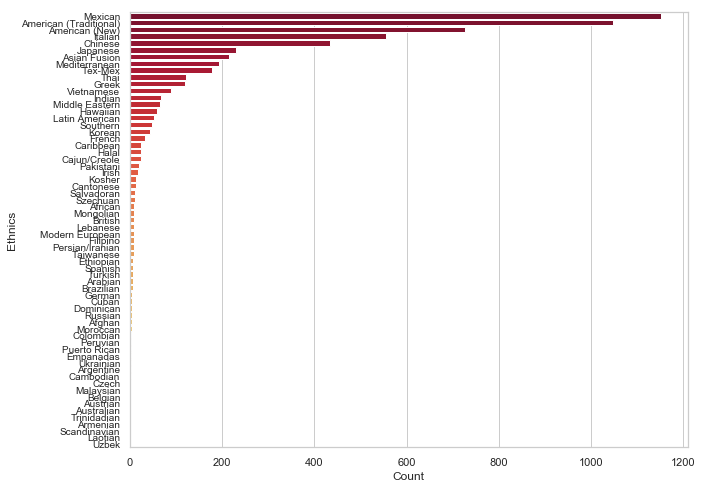

In [24]:
# Visualize dataframe ethnics
plt.figure(figsize=(10,8))
sns.set(style='whitegrid')
ethnics_plot = sns.barplot(x='Count', y='Ethnics', data=ethnics_df,palette ='YlOrRd_r')
ethnics_plot.set_yticklabels(ethnics_plot.get_yticklabels(), fontdict={'fontsize':10});

64 ethnics are too many to us to analyze directly. Therefore, we will combine related ethnics to groups to reduce the number of ethnics.

In [25]:
# Combine ethnics into fewer categories
ethnic_dict = {
'MiddleEast': ['Arabian', 'Armenian', 'Halal','Lebanese','Middle Eastern','Turkish','Mediterranean',
              'Afghan','Pakistani','Persian/Iranian'],
'African': ['African', 'Ethiopian', 'Moroccan'],
'American': ['American (New)', 'American (Traditional)','Hawaiian','Southern'],
'European': ['Austrian', 'Belgian', 'British', 'Czech','French','German','Greek','Irish','Italian',
               'Kosher','Modern European','Cajun/Creole','Scandinavian','Spanish','Australian'],
'Chinese': ['Cantonese', 'Chinese','Szechuan','Taiwanese'],
'LatinAmerica': ['Argentine', 'Brazilian', 'Caribbean', 'Colombian', 'Cuban', 'Dominican', 'Empanadas',
                     'Latin American', 'Peruvian', 'Puerto Rican', 'Salvadoran', 'Trinidadian'],
'SouthEastAisa': ['Cambodian', 'Filipino','Laotian', 'Malaysian', 'Thai', 'Vietnamese','Indian'],
'EastAsia': ['Japanese', 'Korean', 'Asian Fusion'],
'Mexican': ['Mexican','Tex-Mex'],
'AsiaContinent': ['Mongolian','Russian','Ukrainian','Uzbek']
}

In [26]:
# Merge ethnics into smaller categories
merge_ethnic = lambda row: np.unique([ethnic if x in ethnic_dict[ethnic] else x for x in row])
for ethnic in ethnic_dict.keys():
    business_df['ethnics'] = business_df['ethnics'].apply(merge_ethnic)

In [27]:
# Update dictionary
ethnics = ethnic_dict.keys()
ethnics_dict = dict(zip(ethnics, [sum([x in row for row in business_df['ethnics']]) for x in ethnics]))
print('Total Number of Ethnics:', len(ethnics_dict))

C:\Users\Syen Yang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


Total Number of Ethnics: 10


In [28]:
# Print dictionary
ethnics_dict

{'MiddleEast': 239,
 'African': 18,
 'American': 1632,
 'European': 780,
 'Chinese': 439,
 'LatinAmerica': 88,
 'SouthEastAisa': 277,
 'EastAsia': 416,
 'Mexican': 1175,
 'AsiaContinent': 15}

We notice that there are sill three ethnics with frequency less than 200. Therefore, we will combine them in one group `Other`.

In [29]:
# Group ethnics
other = ['African','LatinAmerica','AsiaContinent']

In [30]:
# Update feature ethnics
business_df['ethnics'] = business_df['ethnics'].apply(lambda row: np.unique(['Other' if x in other
                                                                             else x for x in row]))

In [31]:
# Update dictionary
ethnics = ['MiddleEast','American','European','Chinese','SouthEastAisa','EastAsia','Mexican','Other']
ethnics_dict = dict(zip(ethnics, [sum([x in row for row in business_df['ethnics']]) for x in ethnics]))
print('Total Number of Ethnics:', len(ethnics_dict))

C:\Users\Syen Yang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


Total Number of Ethnics: 8


In [32]:
# Convert dictionary to dataframe
ethnics_df = pd.DataFrame(list(ethnics_dict.items()),columns=['Ethnics','Count']).sort_values('Count',ascending = False).reset_index()
ethnics_df = ethnics_df.drop('index', axis=1)

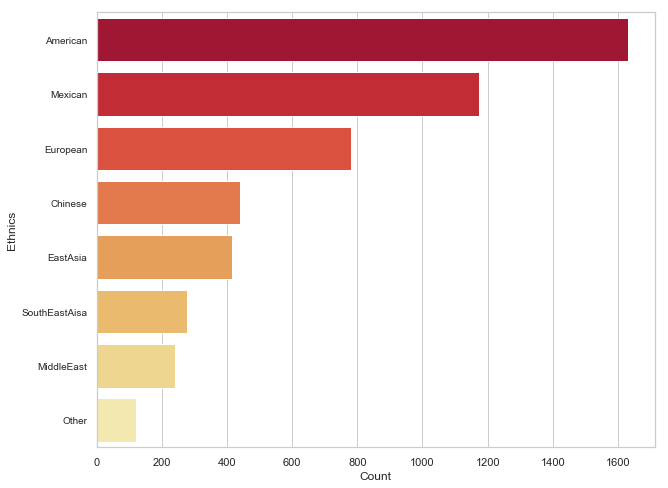

In [33]:
# Visualize dataframe ethnics
plt.figure(figsize=(10,8))
sns.set(style='whitegrid')
ethnics_plot = sns.barplot(x='Count', y='Ethnics', data=ethnics_df, palette ='YlOrRd_r')
ethnics_plot.set_yticklabels(ethnics_plot.get_yticklabels(), fontdict={'fontsize':10});

In [34]:
# Reveal first few rows
business_df['ethnics'].head(10)

0                 []
1                 []
2                 []
3                 []
4    [SouthEastAisa]
5         [American]
6                 []
7                 []
8         [EastAsia]
9    [SouthEastAisa]
Name: ethnics, dtype: object

### Restaurant categories II - Food Types

In [35]:
# Type words filtered by manually check
types = ['Acai Bowls', 'Bagels','Bubble Tea','Burgers', 'Cheesesteaks','Chicken Wings','Creperies','Cupcakes',
         'Custom Cakes','Do-It-Yourself Food','Donuts','Falafel','Fish & Chips','Fondue','Fruits & Veggies',
         'Gelato','Gluten-Free', 'Hot Dogs', 'Hot Pot', 'Ice Cream & Frozen Yogurt', 
         'Imported Food','Juice Bars & Smoothies', 'Kebab','Live/Raw Food','Local Flavor', 'Macarons','Noodles',
         'Pita', 'Pizza', 'Poutineries','Sandwiches','Pretzels','Ramen','Rotisserie Chicken','Salad',
         'Seafood','Shaved Ice', 'Shaved Snow', 'Soup', 'Tacos', 'Teppanyaki',
         'Waffles', 'Wraps','Bakeries', 'Barbeque', 'Beverage Store', 'Buffets','Cafes',
         'Cafeteria', 'Candy Stores','Caterers', 'Cheese Shops','Chicken Shop','Chocolatiers & Shops',
         'Coffee & Tea', 'Coffee & Tea Supplies', 'Coffee Roasteries','Coffeeshops','Desserts',
         'Dim Sum','Delis','Fast Food','Food Court','Food Stands','Food Trucks','Hotels',
         'Hotels & Travel','Internet Cafes', 'New Mexican Cuisine',
         'Organic Stores', 'Pan Asian','Pasta Shops','Patisserie/Cake Shop', 'Popcorn Shops', 'Seafood Markets',
         'Steakhouses','Sushi Bars','Tea Rooms', 'Themed Cafes','Vegan', 'Vegetarian',
         'Bars','Beer', 'Beer Bar','Beer Gardens','Brasseries', 'Breweries', 'Brewpubs','Champagne Bars',
         'Cocktail Bars','Distilleries','Dive Bars','Gay Bars', 'Gastropubs','Hotel bar','Izakaya','Irish Pub',
         'Piano Bars', 'Pubs','Speakeasies','Sports Bars','Tapas Bars','Whiskey Bars','Wine & Spirits','Wine Bars',
         'Wineries']

In [36]:
# Create new feature types
business_df['types'] = business_df['categories'].apply(lambda row: [x for x in row if x in types])

In [37]:
# Create a dictionary to store the appear times of each types
types_dict = dict(zip(types, [sum([x in row for row in business_df['types']]) for x in types]))
print('Total Number of Types:', len(types_dict))

Total Number of Types: 106


Same with `ethnics`, we will group words for feature `type`.

In [38]:
# # Combine types into fewer categories
type_dict = {
    'Fast Food': ['Burgers','Fish & Chips','Hot Dogs','Sandwiches','Fast Food'],
    'Alcohol': ['Bars','Beer', 'Beer Bar','Beer Gardens','Brasseries', 'Breweries', 'Brewpubs','Champagne Bars',
                'Cocktail Bars','Distilleries','Dive Bars','Gay Bars', 'Gastropubs','Hotel bar','Izakaya',
                'Irish Pub','Piano Bars', 'Pubs','Speakeasies','Sports Bars','Tapas Bars','Whiskey Bars',
                'Wine & Spirits','Wine Bars', 'Wineries'],
    'Beverage': ['Bubble Tea','Juice Bars & Smoothies','Beverage Store'],
    'Bakeries & Desserts': ['Bagels','Cupcakes','Custom Cakes','Patisserie/Cake Shop','Shaved Ice','Shaved Snow',
                            'Gelato','Ice Cream & Frozen Yogurt','Macarons','Chocolatiers & Shops','Donuts',
                            'Waffles','Bakeries','Desserts','Creperies'],
    'Vegetarian': ['Fruits & Veggies','Vegan','Vegetarian','Falafel','Acai Bowls'],
    'Coffee & Tea': ['Coffee Roasteries','Coffeeshops','Tea Rooms','Coffee & Tea','Coffee & Tea Supplies','Cafes',
                    'Internet Cafes','Themed Cafes'],
    'Noodles': ['Noodles','Ramen','Pasta Shops'],
    'Seafood': ['Seafood Markets','Seafood'],
    'Snacks': ['Pretzels','Candy Stores','Popcorn Shops'],
    'Chicken': ['Rotisserie Chicken','Chicken Shop','Chicken Wings'],
    'Meat': ['Barbeque','Delis','Steakhouses','Cheesesteaks'],
    'Asian Ethnics': ['Hot Pot','Kebab','Teppanyaki','Dim Sum','Pan Asian','Sushi Bars'],
    'SpecialLocations': ['Food Stands','Food Trucks','Food Court','Hotels','Hotels & Travel']
}

Other = ['Do-It-Yourself Food','Fondue','Gluten-Free',
              'Imported Food','Live/Raw Food','Local Flavor','Pita', 'Pizza', 'Poutineries','Salad','Soup',
              'Tacos', 'Wraps','Buffets','Cafeteria','Caterers','Cheese Shops', 'New Mexican Cuisine',
              'Organic Stores']

In [39]:
# Update feature types
for tp in type_dict.keys():
    business_df['types'] = business_df['types'].apply(lambda row: np.unique([tp if x in type_dict[tp]
                                                                       else x for x in row]))

In [40]:
# Update  dictionary
types = ['Fast Food','Alcohol','Beverage','Bakeries & Desserts','Vegetarian','Coffee & Tea','Noodles','Seafood',
        'Snacks','Chicken','Meat','Asian Ethnics','SpecialLocations'] + Other
type_dict = dict(zip(types, [sum([x in row for row in business_df['types']]) for x in types]))
print('Total Number of Types:', len(type_dict))

C:\Users\Syen Yang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


Total Number of Types: 32


In [41]:
# Convert dictionary to dataframe
type_df = pd.DataFrame(list(type_dict.items()),columns=['Type','Count']).sort_values('Count',ascending = False).reset_index()
type_df = type_df.drop('index', axis=1)

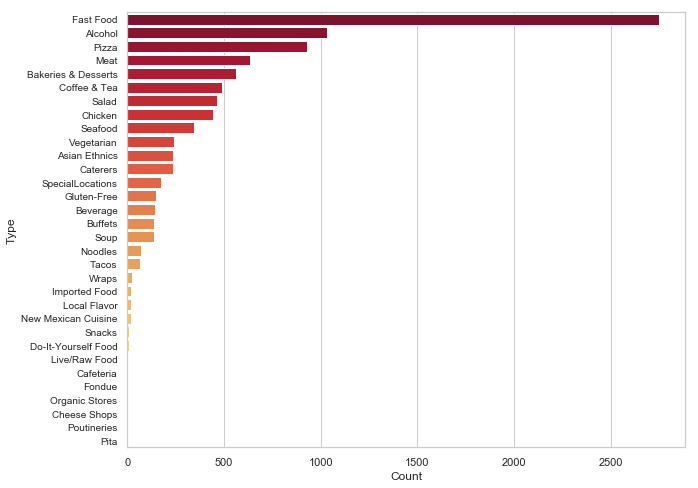

In [42]:
# Visualize dataframe types
plt.figure(figsize=(10,8))
sns.set(style='whitegrid')
types_plot = sns.barplot(x='Count', y='Type', data=type_df, palette ='YlOrRd_r')
types_plot.set_yticklabels(types_plot.get_yticklabels(), fontdict={'fontsize':10});

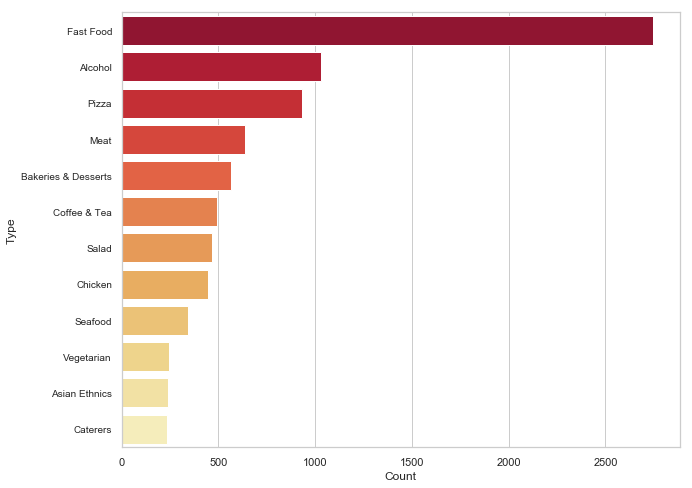

In [43]:
# Visualize dataframe types with more than 200 restaurants
plt.figure(figsize=(10,8))
sns.set(style='whitegrid')
types_plot = sns.barplot(x='Count', y='Type', data=type_df[type_df['Count']>200], palette ='YlOrRd_r')
types_plot.set_yticklabels(types_plot.get_yticklabels(), fontdict={'fontsize':10});

In [44]:
# Reveal first few rows
business_df['types'].head(10)

0               [Fast Food]
1               [Fast Food]
2               [Fast Food]
3                   [Pizza]
4    [Gluten-Free, Seafood]
5                 [Seafood]
6         [Fast Food, Meat]
7        [Fast Food, Pizza]
8        [Alcohol, Noodles]
9                 [Noodles]
Name: types, dtype: object

### Restaurant categories III - Time of the Day

In [45]:
# Time words filtered by manually check
time = ['Bed & Breakfast', 'Breakfast & Brunch', 'Dinner Theater', 'Nightlife']

In [46]:
# Create new feature time
business_df['time_of_day'] = business_df['categories'].apply(lambda row: [x for x in row if x in time])

In [47]:
def clean_time(x):
    # Check if the list is not empty
    if len(x) > 0:
        # Replace punctuation and split by space
        items =  re.sub(r'\s?[&,]', '', x[0]).split()
        
        # Append keywords
        if 'Nightlife' in items:
            items += ['Dinner', 'Latenight']
        
        # Filter unwanted words
        return [x.lower() for x in items if x not in ['Bed', 'Theater', 'Nightlife']]
    else:
        return x

In [48]:
# Process the strings
business_df['time_of_day'] = business_df['time_of_day'].apply(clean_time)

In [49]:
# Calculate the frequencies for each time of day
time = np.unique([x for row in business_df['time_of_day'] for x in row])
time_dist = dict(zip(time, [sum([x in row for row in business_df['time_of_day'] if len(row) > 0]) for x in time]))
time_df = pd.DataFrame(list(time_dist.items()), columns=['Time of Day','Count']) \
                .sort_values('Count', ascending = False) \
                .reset_index() \
                .drop('index', axis=1)

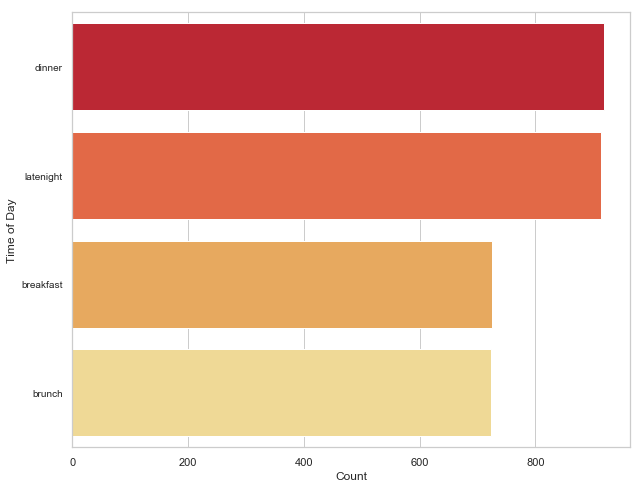

In [50]:
# Visualize dataframe types with more than 200 restaurants
plt.figure(figsize=(10,8))
sns.set(style='whitegrid')
time_plot = sns.barplot(x='Count', y='Time of Day', data=time_df, palette='YlOrRd_r')
time_plot.set_yticklabels(time_plot.get_yticklabels(), fontdict={'fontsize': 10});

In [51]:
business_df['time_of_day'].value_counts()

[]                     5473
[dinner, latenight]     914
[breakfast, brunch]     724
[dinner]                  4
[breakfast]               1
Name: time_of_day, dtype: int64

From the value counts, we notice that there are over 5000 missing values in `time_of_day` feature. In other words, `categories` does not give us enough information about the opening time of the day. However, we notice that `attributes` provides us with more information about eh opening time of day. Therefore, we will `attributes` to extract `time_of_day` better.

## Extract Features From Attributes

In [52]:
# Convert feature attributes to a dataframe
attributes_df = business_df['attributes'].apply(pd.Series)

In [53]:
# Reveal first few rows
attributes_df.head()

,RestaurantsTableService,GoodForMeal,Alcohol,Caters,HasTV,RestaurantsGoodForGroups,NoiseLevel,WiFi,RestaurantsAttire,RestaurantsReservations,...,GoodForDancing,Music,BestNights,CoatCheck,Smoking,ByAppointmentOnly,RestaurantsCounterService,AgesAllowed,AcceptsInsurance,HairSpecializesIn
0,False,"{'dessert': False, 'latenight': False, 'lunch'...",none,False,True,True,loud,free,casual,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,"{'dessert': False, 'latenight': False, 'lunch'...",full_bar,True,True,True,average,free,casual,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,False,"{'dessert': False, 'latenight': True, 'lunch':...",none,False,False,True,loud,paid,casual,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,True,"{'dessert': False, 'latenight': False, 'lunch'...",full_bar,True,True,True,average,free,casual,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Since we have too many features in `attibutes` which makes it hard to us to analyze. Threrefore, we will drop some fearures.

In [55]:
# Reveal names of features with missing values less than half of the total observation numbers in attributes
attributes_df.isna().sum()[attributes_df.isna().sum() < attributes_df.shape[0]/2].to_dict().keys()

dict_keys(['RestaurantsTableService', 'GoodForMeal', 'Alcohol', 'Caters', 'HasTV', 'RestaurantsGoodForGroups', 'NoiseLevel', 'WiFi', 'RestaurantsAttire', 'RestaurantsReservations', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'RestaurantsPriceRange2', 'BikeParking', 'RestaurantsDelivery', 'Ambience', 'RestaurantsTakeOut', 'GoodForKids', 'BusinessParking', 'WheelchairAccessible'])

Remove List: <br>
`Ambience`: `RestaurantsAttire` gives similar but better information <br>
`BikeParking`: not that important 

In [58]:
# Reveal names of features with missing values no less than half of the total observation numbers in attributes
attributes_df.isna().sum()[attributes_df.isna().sum() >= attributes_df.shape[0]/2].to_dict().keys()

dict_keys(['DriveThru', 'BusinessAcceptsBitcoin', 'Open24Hours', 'BYOBCorkage', 'BYOB', 'Corkage', 'DogsAllowed', 'DietaryRestrictions', 'HappyHour', 'GoodForDancing', 'Music', 'BestNights', 'CoatCheck', 'Smoking', 'ByAppointmentOnly', 'RestaurantsCounterService', 'AgesAllowed', 'AcceptsInsurance', 'HairSpecializesIn'])

Remove List: <br>
`BusinessAcceptsBitcoin`: not that important <br>
`Open24Hours`: interested but only 2 True values <br>
`BYOBCorkage`: not that important <br>
`BYOB`: not that important <br>
`Corkage`: not that important <br>
`DietaryRestrictions`: not that important <br>
`GoodForDancing`: too many NA's and not that important <br>
`Music`: too many NA's <br>
`BestNights`: too many NA's <br>
`CoatCheck`: too many NA's and not that important <br>
`ByAppointmentOnly`: too many NA's <br>
`RestaurantsCounterService`: too many NA's <br>
`AgesAllowed`: too many NA's <br>
`AcceptsInsurance`: too many NA's and not that important <br>
`HairSpecializesIn`: too many NA's and not that important <br>

In [62]:
# Drop features
attributes_df=attributes_df.drop(['Ambience','BikeParking','BusinessAcceptsBitcoin','Open24Hours','BYOBCorkage',
                                 'BYOB','Corkage','DietaryRestrictions','GoodForDancing',
                                 'Music','BestNights','CoatCheck','ByAppointmentOnly','RestaurantsCounterService',
                                 'AgesAllowed','AcceptsInsurance','HairSpecializesIn'], axis=1)

In [63]:
# Check column names
attributes_df.columns

Index(['RestaurantsTableService', 'GoodForMeal', 'Alcohol', 'Caters', 'HasTV',
       'RestaurantsGoodForGroups', 'NoiseLevel', 'WiFi', 'RestaurantsAttire',
       'RestaurantsReservations', 'OutdoorSeating',
       'BusinessAcceptsCreditCards', 'RestaurantsPriceRange2',
       'RestaurantsDelivery', 'RestaurantsTakeOut', 'GoodForKids', 'DriveThru',
       'BusinessParking', 'WheelchairAccessible', 'DogsAllowed', 'HappyHour',
       'Smoking'],
      dtype='object')

In [64]:
# Define name change in key-value pairs
column_name_change = {
    'RestaurantsTableService':'tableService',
    'GoodForMeal':'openFor',
    'Alcohol':'alcohol',
    'Caters':'caters',
    'HasTV':'hasTV',
    'RestaurantsGoodForGroups':'forGroups',
    'NoiseLevel':'noiceLevel',
    'WiFi':'hasWiFi',
    'RestaurantsAttire':'attire',
    'RestaurantsReservations':'reservations',
    'OutdoorSeating':'outdoorSeating',
    'BusinessAcceptsCreditCards':'acceptCreditCard',
    'RestaurantsPriceRange2':'priceRange',
    'RestaurantsDelivery':'delivery',
    'RestaurantsTakeOut':'takeOut',
    'GoodForKids':'goodForKids',
    'DriveThru':'driveThru',
    'BusinessParking':'businessParking',
    'WheelchairAccessible': 'wheelchairAccessible',
    'DogsAllowed': 'dogsAllowed',
    'HappyHour':'happyHour',
    'Smoking':'smoking'}

In [65]:
# Change names for some variables
attributes_df = attributes_df.rename(columns=column_name_change)

In [66]:
# Reveal first few rows
attributes_df.head()

,tableService,openFor,alcohol,caters,hasTV,forGroups,noiceLevel,hasWiFi,attire,reservations,...,priceRange,delivery,takeOut,goodForKids,driveThru,businessParking,wheelchairAccessible,dogsAllowed,happyHour,smoking
0,False,"{'dessert': False, 'latenight': False, 'lunch'...",none,False,True,True,loud,free,casual,False,...,1.0,False,True,True,True,"{'garage': False, 'street': False, 'validated'...",NaN,NaN,NaN,NaN
1,True,"{'dessert': False, 'latenight': False, 'lunch'...",full_bar,True,True,True,average,free,casual,False,...,2.0,True,True,True,False,"{'garage': False, 'street': False, 'validated'...",NaN,NaN,NaN,NaN
2,False,"{'dessert': False, 'latenight': True, 'lunch':...",none,False,False,True,loud,paid,casual,False,...,1.0,False,True,True,True,"{'garage': False, 'street': False, 'validated'...",True,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,True,"{'dessert': False, 'latenight': False, 'lunch'...",full_bar,True,True,True,average,free,casual,True,...,2.0,True,True,True,NaN,"{'garage': False, 'street': False, 'validated'...",True,True,NaN,NaN


### Restaurant categories III - By Time of The Day - Continue
We notice that feature `time` have values in dictionary format. we will break the dictionaries and convert them lists. 

In [67]:
# Convert feature time to a dataframe
openFor_df = attributes_df['openFor'].apply(pd.Series)

C:\Users\Syen Yang\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexes\api.py:107: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  result = result.union(other)
C:\Users\Syen Yang\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexes\api.py:69: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  index = _union_indexes(indexes, sort=sort)
C:\Users\Syen Yang\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexes\api.py:107: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)


In [68]:
# Reveal first few rows
openFor_df.head()

,dessert,latenight,lunch,dinner,breakfast,brunch,0
0,False,False,True,False,True,False,NaN
1,False,False,False,True,False,False,NaN
2,False,True,True,True,True,False,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,False,False,False,True,False,False,NaN


In [69]:
# Drop unnecessary variable
openFor_df = openFor_df.drop(0,axis=1)

In [70]:
# Change names of features
openFor_df = openFor_df.rename(columns={'dessert':'Dessert',
                                        'latenight':'Latenight',
                                        'lunch':'Lunch',
                                        'dinner':'Dinner',
                                        'breakfast':'Breakfast',
                                        'brunch':'Brunch'})                               

In [71]:
# Check NA's
openFor_df.isna().sum()

Dessert      641
Latenight    641
Lunch        641
Dinner       641
Breakfast    641
Brunch       641
dtype: int64

In [72]:
# Fill NA's
openFor_df['Dessert'] = openFor_df['Dessert'].fillna(business_df['types'].apply(lambda row: 'Desserts' in row))
openFor_df['Latenight'] = openFor_df['Latenight'].fillna(business_df['time_of_day'].apply(lambda row: 'Latenight' in row))
openFor_df['Lunch'] = openFor_df['Lunch'].fillna(business_df['time_of_day'].apply(lambda row: 'Lunch' in row))
openFor_df['Dinner'] = openFor_df['Dinner'].fillna(business_df['time_of_day'].apply(lambda row: 'Dinner' in row))
openFor_df['Breakfast'] = openFor_df['Breakfast'].fillna(business_df['time_of_day'].apply(lambda row: 'Breakfast' in row))
openFor_df['Brunch'] = openFor_df['Brunch'].fillna(business_df['time_of_day'].apply(lambda row: 'Brunch' in row))

C:\Users\Syen Yang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


In [73]:
# Create new feature openTime with a series of lists
openFor_df['time'] = pd.Series()
openFor_df['time'] = openFor_df['time'].apply(lambda x: [])

In [74]:
# Convert several features into one
openFor_ls = ['Latenight','Lunch','Dinner','Breakfast','Brunch']
for i in range(len(openFor_df['time'])):
    for j in openFor_ls:
        if str(openFor_df[j].iloc[i])=='True':
            openFor_df['time'].iloc[i].append(j)

In [75]:
# Convert dictionary to dataframe
openFor_dict = dict(zip(openFor_ls, [[x in row for row in openFor_df['time']].count(True) for x in openFor_ls]))
openFor_plot_df = pd.DataFrame(list(openFor_dict.items()),columns=['openFor','Count']).sort_values('Count',ascending = False).reset_index()
openFor_plot_df = openFor_plot_df.drop('index', axis=1);

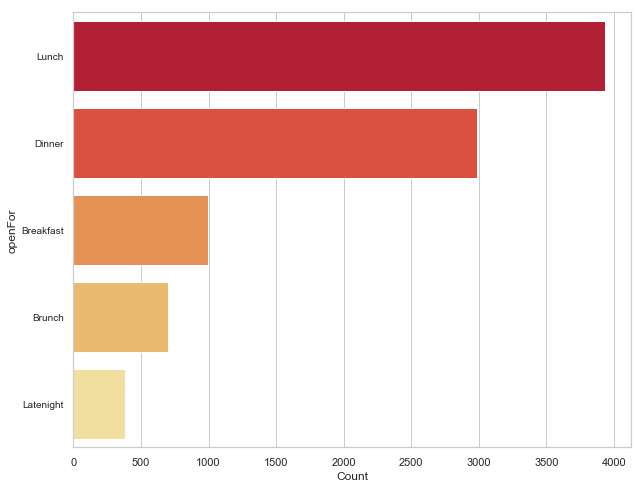

In [76]:
# Visualize dataframe types
plt.figure(figsize=(10,8))
sns.set(style='whitegrid')
openFor_plot = sns.barplot(x='Count', y='openFor', data=openFor_plot_df,palette='YlOrRd_r')
openFor_plot.set_yticklabels(openFor_plot.get_yticklabels(), fontdict={'fontsize':10});

In [77]:
# Reveal first few rows
openFor_df['time'].head(10)

0                       [Lunch, Breakfast]
1                                 [Dinner]
2    [Latenight, Lunch, Dinner, Breakfast]
3                                       []
4                                 [Dinner]
5                                 [Dinner]
6                          [Lunch, Dinner]
7                                       []
8                          [Lunch, Dinner]
9                          [Lunch, Dinner]
Name: time, dtype: object

Now, we will drop our original feature `time` and replace it with new `time` extracted from `attributes`. At the same time, we will also merge feature `dessert` in our business dataset.

In [78]:
# Drop variables
business_df = business_df.drop('time_of_day',axis=1)
attributes_df = attributes_df.drop('openFor', axis=1)
openFor_df = openFor_df.drop(['Latenight','Lunch','Dinner','Breakfast','Brunch'], axis=1)

In [79]:
# Merge to our data
business_df = business_df.merge(openFor_df, left_index=True, right_index=True)

### Clean NA's for Alcohol

In [80]:
# Check number of NA's
print('Number of Missing Values in Alcohol:', attributes_df['alcohol'].isna().sum())

Number of Missing Values in Alcohol: 948


In [81]:
# Fill NA's
attributes_df['alcohol'] = attributes_df['alcohol']\
     .fillna(business_df['types'].apply(lambda row: 'True' if 'Alcohol' in row else np.nan))
print('Number of Missing Values in Alcohol:', attributes_df['alcohol'].isna().sum())

Number of Missing Values in Alcohol: 903


C:\Users\Syen Yang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


In [82]:
# Check value counts
attributes_df['alcohol'].value_counts()

none             3405
full_bar         1896
beer_and_wine     867
True               45
Name: alcohol, dtype: int64

Now we will do some combinations: <br>
`none`, `False` -> `False` <br>
`full_bar`, `beer_and_wine`, `True` -> `True`.

In [83]:
# Change value names
attributes_df['alcohol'] = attributes_df['alcohol'].str.replace('none', 'False')
attributes_df['alcohol'] = attributes_df['alcohol'].str.replace('full_bar', 'True')
attributes_df['alcohol'] = attributes_df['alcohol'].str.replace('beer_and_wine', 'True')

In [84]:
# Convert values to boolean
attributes_df['alcohol'] = attributes_df['alcohol'].apply(lambda x: (x=='True') if not pd.isna(x) else x)

### Break Dictionaries for BusinessParking

In [85]:
# Break dictionary businessParking
businessParking_df = attributes_df['businessParking'].apply(pd.Series)
businessParking_df = businessParking_df.drop(0,axis=1)

In [86]:
# Merge to attributes_df
attributes_df = attributes_df.merge(businessParking_df, left_index=True, right_index=True)

In [87]:
# Drop variable
attributes_df = attributes_df.drop('businessParking', axis=1)

In [88]:
# Check dimensions
attributes_df.shape

(7116, 25)

## Final Merge And Output

In [89]:
#Merge arrtributes back to business
business_df = business_df.merge(attributes_df, left_index=True, right_index=True)

In [90]:
# Drop orginal arrtributes in business
business_df = business_df.drop('attributes', axis=1)

In [91]:
# Check dimensions
business_df.shape

(7116, 45)

In [92]:
#Print all column names
business_df.columns

Index(['business_id', 'categories', 'city', 'latitude', 'longitude', 'name',
       'postal_code', 'review_count', 'stars', 'state', 'isBankrupt', 'county',
       'isChain', 'density', 'cluster', 'neighborhood', 'ethnics', 'types',
       'Dessert', 'time', 'tableService', 'alcohol', 'caters', 'hasTV',
       'forGroups', 'noiceLevel', 'hasWiFi', 'attire', 'reservations',
       'outdoorSeating', 'acceptCreditCard', 'priceRange', 'delivery',
       'takeOut', 'goodForKids', 'driveThru', 'wheelchairAccessible',
       'dogsAllowed', 'happyHour', 'smoking', 'garage', 'street', 'validated',
       'lot', 'valet'],
      dtype='object')

## 3.2 Extract Review Features

In [94]:
# Load review data
review = pd.read_csv('clean_review.csv')
review.shape

(781473, 8)

In [95]:
# Look at the first few rows of data
review.head()

,business_id,cool,date,funny,stars,useful,review_length,clean_text
0,JlNeaOymdVbE6_bubqjohg,0,2014-08-09,0,1,3,81,chevo chandler delicious ahwatukee different r...
1,0Rni7ocMC_Lg2UH0lDeKMQ,0,2014-08-09,0,1,6,21,place dirty grimy twice service horrible
2,S-oLPRdhlyL5HAknBKTUcQ,0,2017-11-30,0,4,0,25,holy portion size lot bang buck service super ...
3,iIjVO7cLD1UEmIO7G05Ujw,0,2016-06-11,0,4,0,60,flavor actually pretty good eat menudo tortill...
4,1JF9TbJ2d5hH8xsQvvklHg,0,2016-06-18,0,5,1,94,place great flavor thing ask bring chip salsa ...


In [96]:
# Make a copy of the original data
review_df = review.copy()

## 3.2.1 Create Bag-of-Words Model

We utilize `gensim` library to create bag-of-word models.

The processing steps are shown below:

1. Create corpus from review data.

2. Generate bigrams

3. Create corpus dictionary 

4. Create term-document matrix

5. Compute TF-IDF scores

In [97]:
# Convert string to list
corpus = review_df['clean_text'].apply(lambda x: simple_preprocess(str(x)))

In [98]:
# Creates bigrams
phrases = Phrases(corpus, min_count=1, threshold=1)
corpus = [doc + [bigram for bigram in phrases[doc] if '_' in bigram] for doc in corpus]

In [99]:
# Create a word dictionary
dictionary = Dictionary(corpus)
dictionary.filter_extremes()
dictionary.compactify()

In [100]:
# Create bad-of-word corpus
bow_corpus = [dictionary.doc2bow(doc) for doc in corpus]

In [101]:
# Compute tf-idf
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

## 3.2.2 Topic Modeling

In [102]:
# Compute coherence scores 
def get_coherence_score(corpus, dictionary, texts, start=2, end=3, step=1):
    num_topic = []
    model = []
    coherence = []
    for i in range(start, end+step, step):
        # Create lda models
        lda = LdaModel(corpus=corpus, num_topics=i, id2word=dictionary, random_state=314)
        
        # Create coherence model
        cm = CoherenceModel(model=lda, corpus=corpus, texts=texts, dictionary=dictionary, coherence='c_v')
        
        # Save the models and scores
        num_topic.append(i)
        model.append(lda)
        coherence.append(cm.get_coherence())
        
    return num_topic, model, coherence

In [103]:
%%time
# Try different values of k topics
## 
num_topic, model, coherence = get_coherence_score(tfidf_corpus, dictionary, corpus, start=2, end=20, step=1)

Wall time: 2h 55min 46s


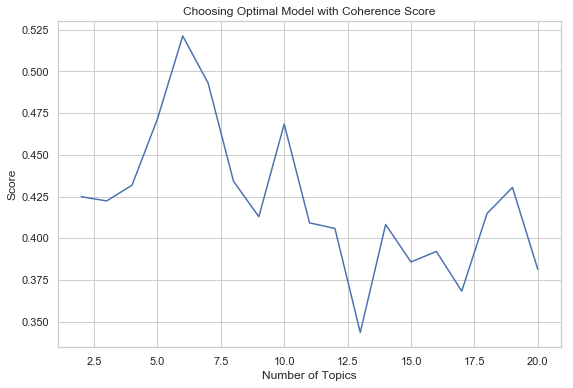

In [104]:
# Plot the coherence score for each number of topics
plt.figure(figsize=(9,6))
plt.plot(num_topic, coherence)
plt.xlabel('Number of Topics')
plt.ylabel('Score')
plt.title('Choosing Optimal Model with Coherence Score');

In [105]:
# Get the best lda model with the ghiest coherence score
best_lda = model[coherence.index(max(coherence))]
print('Best number of topic:', best_lda.num_topics)
print('Best coherence score:', max(coherence))

Best number of topic: 6
Best coherence score: 0.5212264073764619


In [106]:
# Show the components of each topic
best_lda.show_topics(num_words=20)

[(0,
  '0.017*"coffee" + 0.010*"cream" + 0.010*"donut" + 0.010*"gluten" + 0.010*"breakfast" + 0.009*"ice" + 0.008*"pancake" + 0.008*"gluten_free" + 0.008*"ice_cream" + 0.008*"chocolate" + 0.007*"free" + 0.006*"crepe" + 0.006*"cookie" + 0.005*"smoothie" + 0.005*"toast" + 0.005*"vegan" + 0.004*"latte" + 0.004*"shop" + 0.004*"french" + 0.004*"pastry"'),
 (1,
  '0.005*"great" + 0.004*"good" + 0.004*"place" + 0.004*"pizza" + 0.004*"love" + 0.003*"beer" + 0.003*"food" + 0.003*"try" + 0.003*"nice" + 0.003*"menu" + 0.003*"bar" + 0.003*"amazing" + 0.003*"delicious" + 0.003*"salad" + 0.003*"service" + 0.003*"happy" + 0.003*"drink" + 0.003*"friendly" + 0.003*"atmosphere" + 0.003*"come"'),
 (2,
  '0.010*"great" + 0.008*"love" + 0.008*"food" + 0.008*"good" + 0.008*"place" + 0.007*"service" + 0.007*"friendly" + 0.007*"amazing" + 0.006*"delicious" + 0.006*"staff" + 0.006*"price" + 0.006*"recommend" + 0.005*"definitely" + 0.005*"chicken" + 0.005*"fresh" + 0.005*"try" + 0.005*"lunch" + 0.005*"favorite"

In [107]:
# Add topic label manually
topic_label = ['Coffee/Dessert', 
               'Food/Atmosphere', 
               'Food/Service', 
               'Wait Time',
               'Mexican Food',
               'Breakfast']
topic_dict = {i:topic_label[i] for i in range(best_lda.num_topics)}

In [108]:
def find_dominant_topic(x):
    topic_percent = [j for i, j in x]
    return topic_percent.index(max(topic_percent))

In [109]:
# Compute the dominant topic for each review
dominant_topic = pd.get_dummies([find_dominant_topic(x) for x in best_lda[tfidf_corpus]]).rename(columns=topic_dict)
dominant_topic.head()

,Coffee/Dessert,Food/Atmosphere,Food/Service,Wait Time,Mexican Food,Breakfast
0,0,1,0,0,0,0
1,0,0,0,1,0,0
2,0,0,1,0,0,0
3,0,0,0,1,0,0
4,0,0,0,1,0,0


In [110]:
review_df = review_df.merge(dominant_topic, left_index=True, right_index=True)
review_df.shape

(781473, 14)

In [111]:
review_df.head()

,business_id,cool,date,funny,stars,useful,review_length,clean_text,Coffee/Dessert,Food/Atmosphere,Food/Service,Wait Time,Mexican Food,Breakfast
0,JlNeaOymdVbE6_bubqjohg,0,2014-08-09,0,1,3,81,chevo chandler delicious ahwatukee different r...,0,1,0,0,0,0
1,0Rni7ocMC_Lg2UH0lDeKMQ,0,2014-08-09,0,1,6,21,place dirty grimy twice service horrible,0,0,0,1,0,0
2,S-oLPRdhlyL5HAknBKTUcQ,0,2017-11-30,0,4,0,25,holy portion size lot bang buck service super ...,0,0,1,0,0,0
3,iIjVO7cLD1UEmIO7G05Ujw,0,2016-06-11,0,4,0,60,flavor actually pretty good eat menudo tortill...,0,0,0,1,0,0
4,1JF9TbJ2d5hH8xsQvvklHg,0,2016-06-18,0,5,1,94,place great flavor thing ask bring chip salsa ...,0,0,0,1,0,0


## 3.2.3 Sentiment Score

In [112]:
# Compute sentiment score
review_df['polarity'] = review_df['clean_text'].apply(lambda sent: TextBlob(str(sent)).sentiment.polarity)
review_df['subjectivity'] = review_df['clean_text'].apply(lambda sent: TextBlob(str(sent)).sentiment.subjectivity)

## 3.2.4 Review Count

In [113]:
# Caclulate the number of reviews in the dataset
review_count = review_df.groupby('business_id').count().iloc[:,0].to_dict()

## 3.2.5 Restaurant Age

In [114]:
# Convert string date to datetime format
review_df['date'] = review_df['date'].apply(lambda x: pd.to_datetime(x))

In [115]:
# Create dictionary of estimated restaurant age
restaurant_age = review_df[['business_id', 'date']].groupby('business_id') \
                                                    .agg(lambda x: pd.datetime(2017, 12, 31) - min(x))['date'] \
                                                    .apply(lambda x: x.days / 365) \
                                                    .to_dict()

## 3.2.6 Combine Review Features

In [116]:
# Take the mean of numeric features group by business id
review_df = review_df.groupby('business_id').mean().reset_index()

In [117]:
# Create aggregate variables
review_df['restaurant_age'] = review_df['business_id'].apply(lambda row: restaurant_age[row])
review_df['review_count'] = review_df['business_id'].apply(lambda row: restaurant_age[row])
review_df.shape

(7183, 16)

In [118]:
# View the first few lines of data 
review_df.head()

,business_id,cool,funny,stars,useful,review_length,Coffee/Dessert,Food/Atmosphere,Food/Service,Wait Time,Mexican Food,Breakfast,polarity,subjectivity,restaurant_age,review_count
0,-01XupAWZEXbdNbxNg5mEg,0.818182,0.714286,2.857143,1.610390,120.259740,0.00000,0.428571,0.064935,0.480519,0.00000,0.025974,0.184144,0.613380,8.257534,8.257534
1,-092wE7j5HZOogMLAh40zA,0.265060,0.216867,3.349398,1.397590,106.867470,0.00000,0.048193,0.566265,0.337349,0.00000,0.048193,0.149639,0.606846,8.386301,8.386301
2,-0Sgh0QlUKVsWosCWJzGqQ,0.136364,0.477273,1.977273,0.704545,90.340909,0.00000,0.045455,0.045455,0.909091,0.00000,0.000000,0.009063,0.554916,7.326027,7.326027
3,-0WegMt6Cy966qlDKhu6jA,0.376623,0.246753,2.142857,0.662338,124.688312,0.00000,0.259740,0.012987,0.727273,0.00000,0.000000,-0.022920,0.545097,4.712329,4.712329
4,-0aIra_B6iALlfqAriBSYA,0.562500,0.375000,4.625000,0.937500,75.406250,0.03125,0.500000,0.125000,0.281250,0.03125,0.031250,0.324154,0.589466,2.531507,2.531507


## 3.3 Export Finalized Dataset

In [119]:
# Add clean text to dataset

In [120]:
# Combined both dataset and combine the next cell into one dataset

In [121]:
# Export datasets
business_df.to_csv('final_business.csv', index=False)
review_df.to_csv('final_review.csv', index=False)